<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/google_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can open a copy of this notebook in Google Colab by clicking the icon above

---


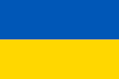 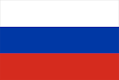
# Effects of Russian invasion of Ukraine on Google search patterns
On february 24th 2022 Vladimir Putin finally invaded Ukraine a second time (the first time was the annexation of Crimea). 

No one can be certain what the exact goal of this "military special operation" (ie. war) really was. But most experts seem to agree on that the results so far have been somewhere between "less than expected" and "catastrophic" for Russia.

In this project I will look at Google search data and try to visualize some trends and patterns in connection to the war. 

The coding is done in `R` and the following packages are used:

* `tidyverse` (including `ggplot2`)
* `gtrendsR` (to fetch data from Google trends)
* `maps` (to create geographic maps)
* `ggthemes` (to create nicer looking plots)

# Setup 
Lets first install and load the necessary packages

In [170]:
# This turns off warning messages, 
# not a good idea when working with the notebook but it makes for a better reading experience when finished
options(warn=-1) 

# To reset warnings --> options(warn=0)

# Install packages
install.packages(c("tidyverse","gtrendsR","maps","ggthemes"))

# Load packages
library(tidyverse)
library(gtrendsR)
library(maps)
library(ggthemes)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Global interest in NATO increased dramatically following Russias invasion of Ukraine
Google Trends normalizes search data to make comparisons between terms easier. Search results are normalized to the time and location of a query by the following process: Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity ([source](https://support.google.com/trends/answer/4365533?hl=en)).

Also, the results are indexed on a scale (1-100). For example, if search volume goes from 1 to 100 the volume has gone up 100-fold. If volume increases from 50 to 100 it has doubled and so forth.

The North Atlantic Treaty Organization (NATO) is a military alliance between 30 member states, of which 28 are in Europe and the other 2 in North America ([wiki](https://en.wikipedia.org/wiki/NATO#:~:text=The%20North%20Atlantic%20Treaty%20Organization,other%202%20in%20North%20America.)).

We'll fetch some data on 'NATO' from Google Trends using the `gtrendsR` package and then visualize it using `ggplot2`.

Let's start by getting data for the keyword "NATO" from 2004 until today and plot it in a nice way.

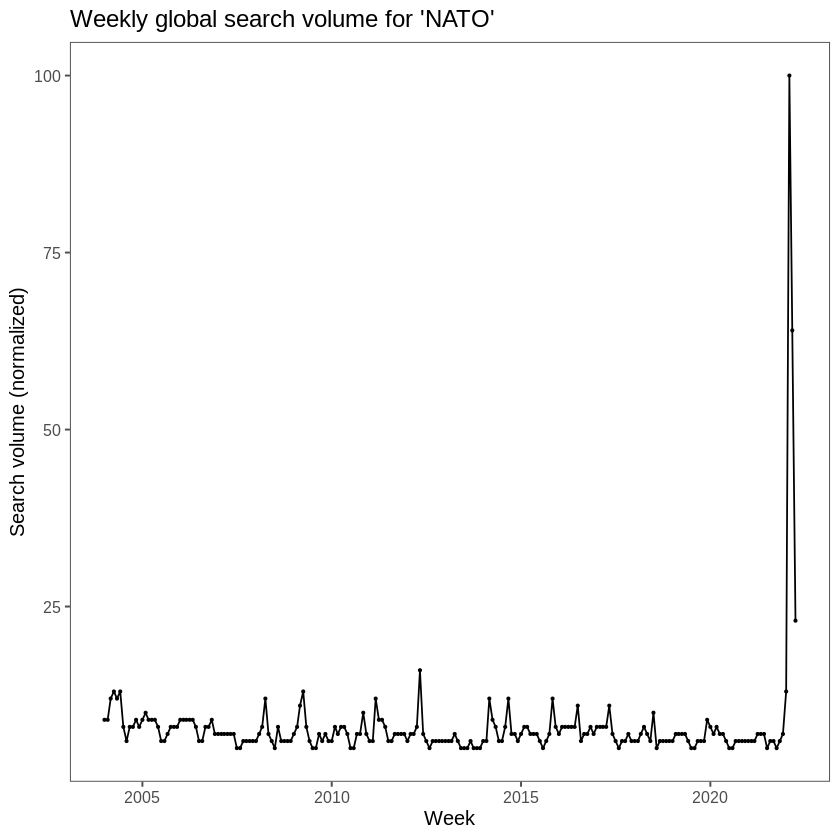

In [171]:
nato = gtrends(c("NATO"), time="all") # Pull search data for keyword 'NATO'. 'Time = "all"' means we'll get data as far back as 2004

nato$interest_over_time %>% # gtrendsR returns a list of dataframes where 'interest_over_time' is time series data
ggplot(aes(x=date,y=hits))+
geom_line(size=0.5)+
geom_point(size=0.5)+
theme_few()+
xlab("Week")+
ylab("Search volume (normalized)")+
labs(title="Weekly global search volume for 'NATO'")




Russias invasion of Ukraine led to a **huge** increase in NATO, as measured by global search volume on Google. Russian invasion of Crimea (the first invasion of Ukraine) in 2014 and the Trump presidency (2017-2021) where NATO was debated a lot doesn't even come close in comparison.

# Similar patterns across different countries

Poland, FInland, Norway and Sweden all have borders against Russia (if we include maritime borders). Poland and Norway are members of NATO, Sweden and Finland are not. Lets compare the search volume for NATO between these four countries around the time of the invasion.

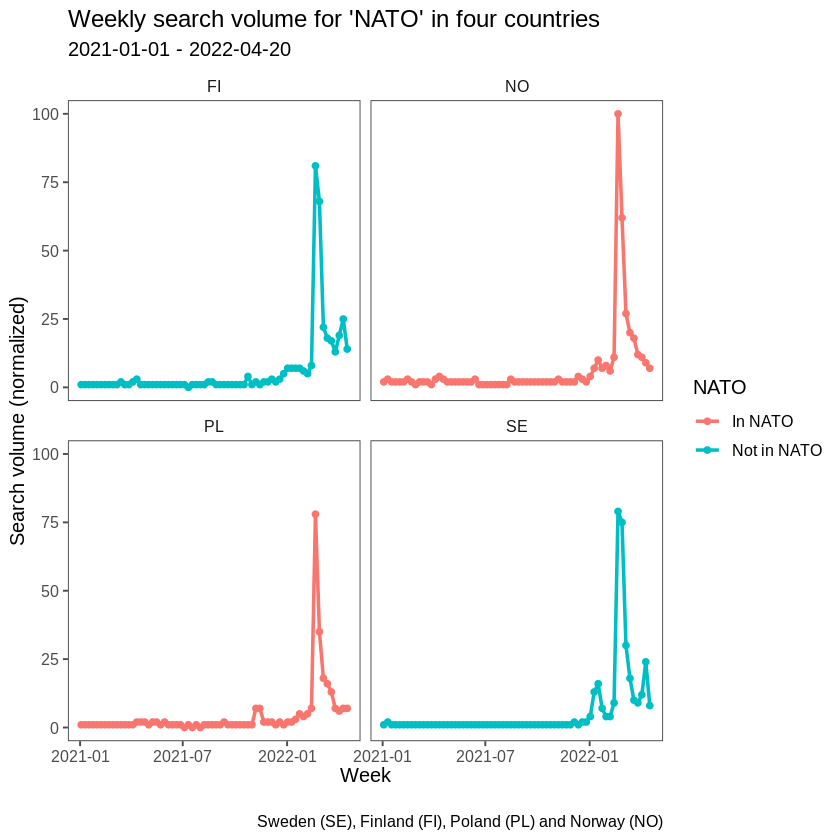

In [172]:
nato_countries = gtrends(c("NATO"),geo=c("SE","FI","PL","NO"),time="2021-01-01 2022-04-20")

nato_countries = nato_countries$interest_over_time

nato_countries = nato_countries %>%
mutate(NATO=case_when(geo=="SE" | geo =="FI" ~ "Not in NATO",
TRUE ~ "In NATO"),
Country=geo) %>%
mutate(hits=as.numeric(ifelse(hits=="<1",0,hits)))

nato_countries %>%
ggplot(aes(x=date,y=hits, color=NATO))+
geom_line(size=1)+
geom_point()+
theme_few()+
xlab("Week")+
ylab("Search volume (normalized)")+
facet_wrap(~Country)+
labs(title="Weekly search volume for 'NATO' in four countries",
subtitle="2021-01-01 - 2022-04-20",
caption="\nSweden (SE), Finland (FI), Poland (PL) and Norway (NO)")


Results look very similar across countries all peaking at the same time (the week of the invasion). But search volume for NATO has perhaps not dropped as much in Sweden and Finland after the invasion.

But it's hard to tell from the graphs. Let's look at daily search data from 2022-02-23 - 2022-04-20 and use `geom_smooth` to cancel out some of the noise.
We'll also overlay all countries to make comparison easier.


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



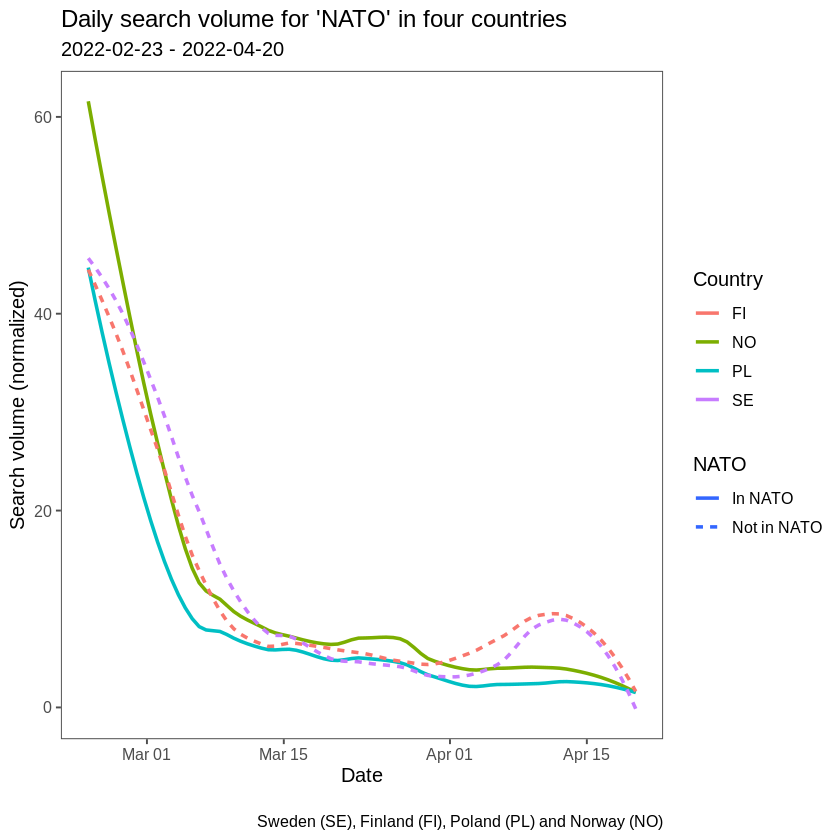

In [173]:
nato_countries = gtrends(c("NATO"),geo=c("SE","FI","PL","NO"),time="2022-02-23 2022-04-20")

nato_countries = nato_countries$interest_over_time

nato_countries = nato_countries %>%
mutate(NATO=case_when(geo=="SE" | geo =="FI" ~ "Not in NATO",
TRUE ~ "In NATO"),
Country=geo) %>%
mutate(hits=as.numeric(ifelse(hits=="<1",0,hits)))

nato_countries %>%
ggplot(aes(x=date,y=hits, linetype=NATO, color=Country))+
geom_smooth(se=F,size=1, span=0.4)+
theme_few()+
xlab("Date")+
ylab("Search volume (normalized)")+
labs(title="Daily search volume for 'NATO' in four countries",
subtitle="2022-02-23 - 2022-04-20",
caption="\nSweden (SE), Finland (FI), Poland (PL) and Norway (NO)")

Looks like there are some similarity between Finland and Sweden. There is a new, smaller, bump in interest around mid of april. This likely reflects both countries debating whether to join NATO together. For example, Finnish PM Sanna Marin met with Swedish PM Magdalena Andersson to discuss NATO on April 13th.

# European countries closest to Russia shows higher increase in search volume for NATO

Let's se if we can highlight other differences between countries regarding searches for 'NATO'

In the following two code chunks we'll do the following:

* Get search data for countries for the period before (2022-01-01 - 2022-02-23) and after (2022-02-24 - 2022-04-21) Russias invasion of Ukraine 
* Compute the increase/decrease (relative other countries) for each contry
* Illustrate the results on a map of Europe and se if we can draw any conclusions from that

Lets start by getting the search data using `gtrendsR` and create a map using the `maps` package.

In [174]:
nato_europe_before = gtrends(c("NATO"),time="2022-01-01 2022-02-23", low_search_volume=T) # Get google trends data from the period before the war
nato_europe_after = gtrends(c("NATO"),time="2022-02-24 2022-04-21", low_search_volume=T) # Get same date from the period after the war


nato_europe_before = nato_europe_before$interest_by_country %>% mutate(id=1) # Extract comparison across countries, id=1 and id=2 to compute lagged difference later
nato_europe_after = nato_europe_after$interest_by_country %>% mutate(id=2) 

nato_europe = rbind(nato_europe_before,nato_europe_after) %>%
group_by(location) %>%
mutate(`Increase in relative search`=lag(hits,order_by=id)) %>% # Get lagged value 
mutate(`Increase in relative search`=as.numeric(hits) - as.numeric(`Increase in relative search`)) %>% #Compute difference between value and lag
ungroup() %>%
filter(id==2) # We only want id=2 because that contains the difference


world = map_data("world") # Get coordinates for world map from 'maps' package 

# Create a list of "euro" countries to use as filter later
european_countries = c("Germany","United Kingdom","France","Italy","Spain","Ukraine","Poland",
"Romania","Netherlands","Belgium","Czechia","Greece","Portugal","Sweden","Hungary","Austria","Serbia",
"Switzerland","Bulgaria","Denmark","Finland","Slovakia","Norway","Ireland","Croatia","Moldova","Bosnia & Herzegovina",
"Albania","Lithuania","North Macedonia","Slovenia","Latvia","Estonia","Montenegro","Luxembourg","Malta","Iceland","Russia","Belarus","Turkey","Kosovo")


# We need to change some labeling to make the world dataframe consistent with the google data
world = world %>% mutate(region = replace(region, region=="USA", "United States")) %>%
  mutate(region = replace(region, region=="UK", "United Kingdom")) %>%
  mutate(region= replace(region, region=="Czech Republic", "Czechia"	)) %>%
  mutate(region = replace(region, region=="Bosnia and Herzegovina","Bosnia & Herzegovina")) %>%
  filter(region %in% european_countries)

# Create a df for plotting that includes only countries in the 'european_countries' vector
plot_df = nato_europe %>%
filter(location %in% european_countries) %>%
 mutate(region = location) %>%
select(region, `Increase in relative search`)


We'll now plot this on a map using `ggplot2` and `maps`

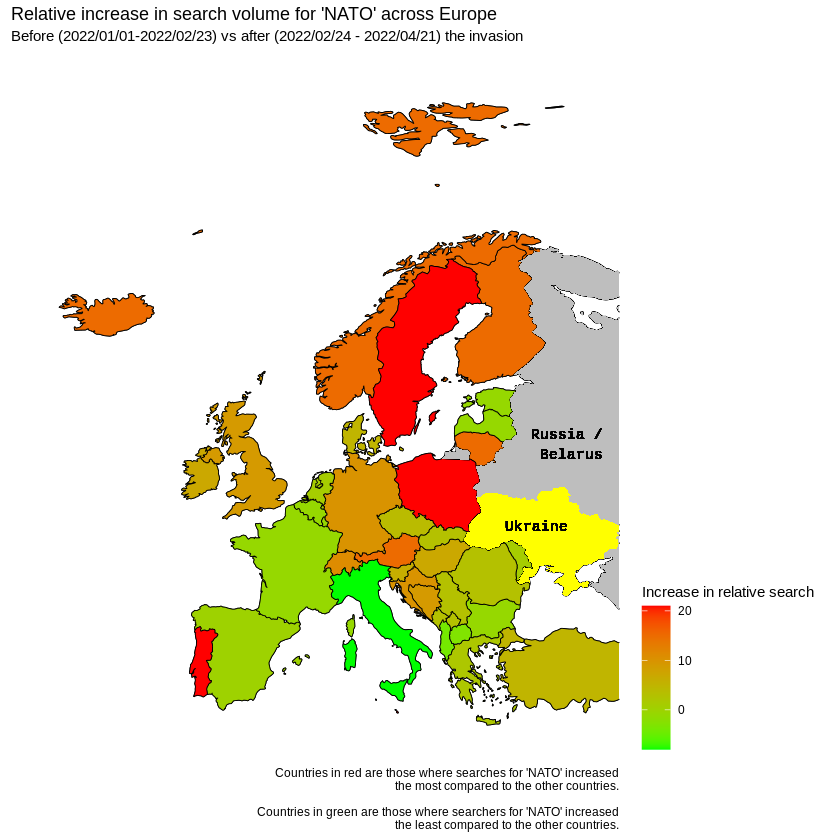

In [175]:
ggplot(world) +
# Create a base map using the 'world' dataframe
  geom_map(map = world,
           aes(x = long, y = lat, map_id = region),
            color="black",fill="white", size=0.25)+
            # Overlay with the search data from google
           geom_map(data = plot_df ,
           map = world,
           aes(fill = `Increase in relative search`, map_id = region), color="black",size=0.25)+
           scale_fill_continuous(low = 'green', high = 'red') +
           # This colors Russia and Belarus in grey
           geom_map(data = plot_df %>% filter(region %in% c("Russia","Belarus")), aes(map_id=region), map=world, fill="grey")+
           # This colors Ukraine in yellow
           geom_map(data = plot_df %>% filter(region =="Ukraine"), aes(map_id=region), map=world, fill="yellow")+
        ggtitle("Search interest for NATO")+
        labs(title="Relative increase in search volume for 'NATO' across Europe",
        subtitle="Before (2022/01/01-2022/02/23) vs after (2022/02/24 - 2022/04/21) the invasion",
        caption="Countries in red are those where searches for 'NATO' increased
        the most compared to the other countries.\n
        Countries in green are those where searchers for 'NATO' increased
        the least compared to the other countries.")+
        scale_x_continuous(limits = c(-30, 40), expand = c(0, 0))+
        theme_map()+
        theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank())+
                theme(legend.position="right") +
                # Label Russia/Belarus and Ukraine
                geom_text(x = 30.5, y = 49.5, label = "Ukraine", size=3, family="mono")+
                geom_text(x = 34.5, y = 55.5, label = "Russia / \nBelarus", size=3, family="mono")
                


Looking at the map, what can we see?

Some countries (Sweden, Poland and Portugal) show the highest increase (relative other countries). Although not perfect (Portugal in red and Estonia/Latvia in green are the most notable exceptions) there seems to be a general pattern that countries located closer to Russia have seen the largest increases in search volume likely reflecting increased interest and political discussions around 'NATO'.

# Desertion is trending on Google search in Russia

**Full disclosure:** I don't speak russian so I haven't been able to asses whether the following translation from english to russian is correct. Please let me know if something gone wrong in the translation (contact details are at the bottom of the page).

'NATO' is one interesting keyword that relates to the war. Another is desertion.

Desertion is the abandonment of a military duty or post without permission and is done with the intention of not returning ([wikipedia](https://en.wikipedia.org/wiki/Desertion)).

According to Google translate the russian word for desertion is `дезертирство`.

If russian soldiers, as have been reported, are unenthusiastic about Putins war then it could be interesting to see if more people than usual are looking into topics related to desertion.

We'll download the search data and create a time series graph.


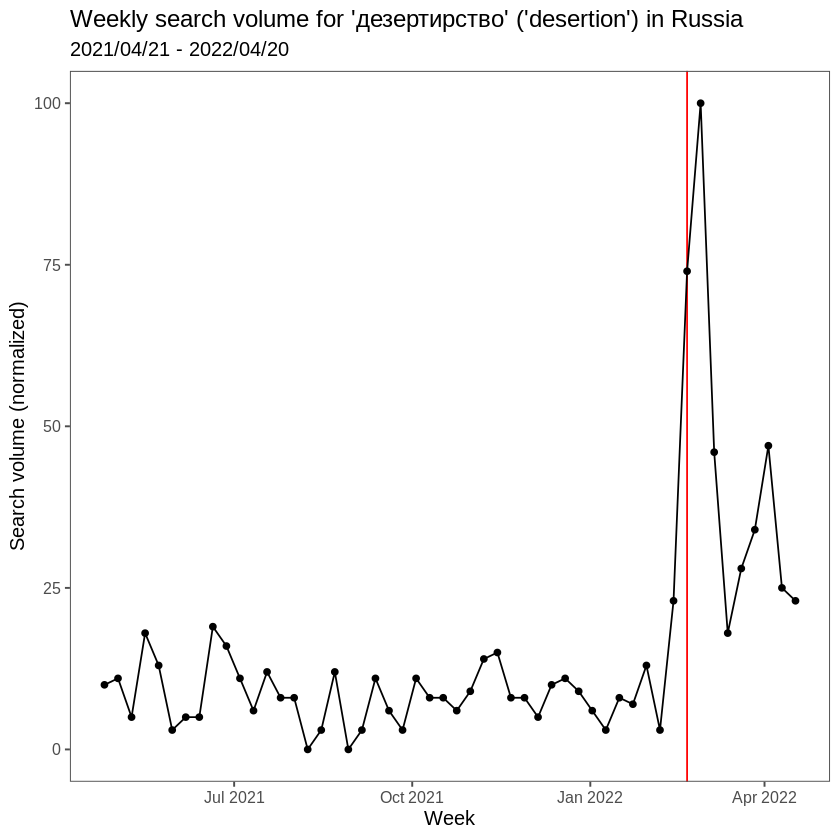

In [176]:
# Weekly search volume for desertion i Russia
desertion = gtrends(c("дезертирство"),geo=c("RU"),time="2021-04-21 2022-04-20", low_search_volume = T)

desertion$interest_over_time %>%
ggplot(aes(x=date, y=hits))+
geom_vline(xintercept = as.POSIXct(as.Date("2022-02-20")), color="red")+
geom_line()+
geom_point()+
xlab("Week")+
ylab("Search volume (normalized)")+
labs(title="Weekly search volume for 'дезертирство' ('desertion') in Russia",
subtitle="2021/04/21 - 2022/04/20")+
theme_few()


The week of the invasion is marked with a red vertical line.

The graph shows that interest in desertion rised the week before the invasion, continued to rise the week of the invasion and peaked the week after that. Since then it has remained at above average levels.

# Russian interest in emigration peaked the week after the invasion but are back at normal levels

Russian soldiers that don't want to fight in Putins war have to make the decision whether to desert (and face possible consequences) or not. Results above indicate that more soldiers than normal are considering this option right now.

But 'ordinary people' (ie. civilians) in Russia are perhaps also thinking about leaving, but not the army rather the country. There have been reports about a lot of people in Russia opposing Putins war, for example at public protests or teachers refusing to tell lies to their pupils. 

Conditions in Russia are likely worse now than a year before with both government oppression and western sanctions contributing to more hardship.

Let's see if this have led to increased Russian interest in emigration.

The russian word for emigrate (according to Google translate, see disclosure above) is `эмигрировать`.

Similar to desertion we'll get search data (from Russia) for `эмигрировать` and create a time series graph.


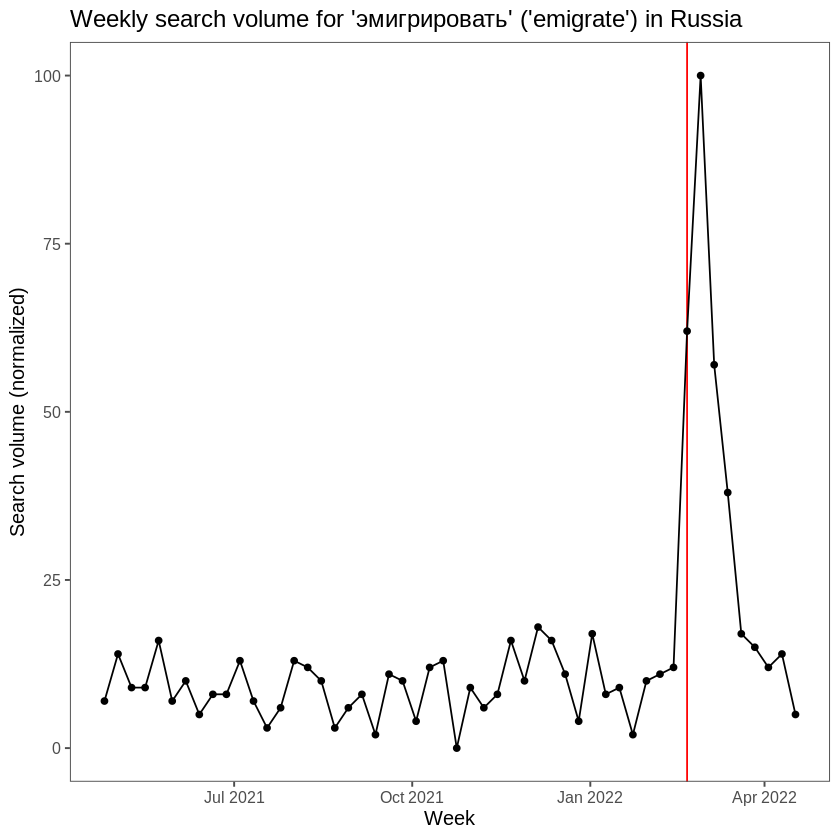

In [177]:
# Weekly search volume for emigrate in Russia
emigrate = gtrends(c("эмигрировать"),geo=c("RU"),time="2021-04-21 2022-04-20", low_search_volume = T)

emigrate$interest_over_time %>%
ggplot(aes(x=date, y=hits))+
geom_vline(xintercept = as.POSIXct(as.Date("2022-02-20")), color="red")+
geom_line()+
geom_point()+
xlab("Week")+
ylab("Search volume (normalized)")+
ggtitle("Weekly search volume for 'эмигрировать' ('emigrate') in Russia")+
theme_few()



The vertical red line represents the week of the invasion.

The graph shows that interest in emigration peaked in Russia the week following the invasion. From the week before the invasion and for the next three weeks the interest was clearly above average. The increased interest is in line with, for example, this article from BBC ([link](https://www.bbc.com/news/world-europe-60697763)).

Since the peak, however, interest in emigration seem to have returned to more normal levels.

# People of Tver, Saint Petersburg and Voronezh show high interest in emigration

Let's see if there are any geographic differences (within Russia) regarding interest in emigration.

We'll download data from Google Trends for the period *after* the invasion and compare differences between cities.'

Unfortunately there's only data available for 19 cities but we'll try to make a comparison depending on location and size (population).

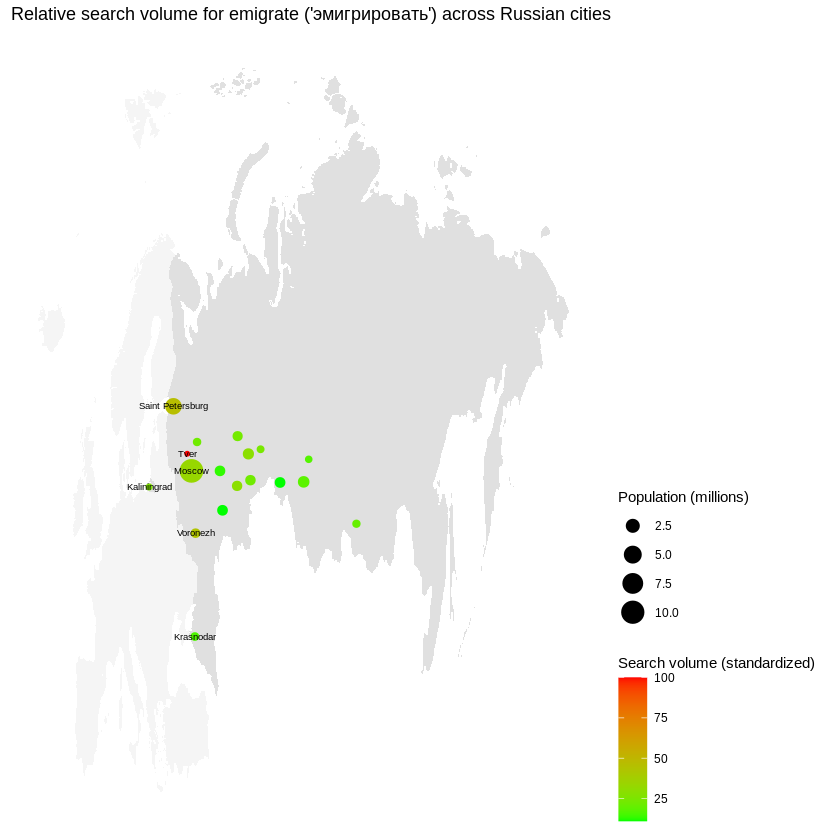

In [178]:
# Get data
emigrate_after_war = gtrends(c("эмигрировать"),geo=c("RU"),time="2022-02-23 2022-04-20", low_search_volume = T)

# The list returned by gtrendsR includes a df 'interest_by_city' 
# This can be joined together with the 'world.cities' df from the 'maps' package
# 'world.cities' contains positional data (long/lat) and pop. size for > 40 000 cities worldwide
russian_cities = emigrate_after_war$interest_by_city %>%
left_join(world.cities %>% filter(country.etc=="Russia"), by=c("location"="name"))

russia_map = world %>% filter(region=="Russia")

plot_df = russian_cities %>%
filter(geo=="RU", !is.na(hits)) %>%
mutate(`Population (millions)`=pop/1000000,
`Search volume (standardized)`=hits)
 
# The world df is the same as we used before to create the base map layer
ggplot(world) +
# This colors the world in a lightgrey color
  geom_map(map = world,
           aes(x = long, y = lat, map_id = region),
            fill="#f5f5f5", size=0.25)+
# This colors Russia in a darker grey 
            geom_map(map = world %>% filter(region=="Russia"), aes(x=long,y=lat, map_id=region),
            fill="#e0e0e0")+
# Add points where size depends on population and fill depends on search volume (relative other cities)
            geom_point(data=plot_df, aes(x=long, y=lat, size=`Population (millions)`, color=`Search volume (standardized)`))+
                       scale_color_continuous(low = 'green', high = 'red') +
                       geom_text(data=plot_df %>% filter(location %in% c("Saint Petersburg","Moscow","Kaliningrad","Krasnodar","Tver","Voronezh")), aes(x=long,y=lat, label=location),size=2)+
            theme_map()+
            theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank())+
                theme(legend.position="right")+
                labs(title="Relative search volume for emigrate ('эмигрировать') across Russian cities")

The map shows that the city of Tver ([wiki](https://en.wikipedia.org/wiki/Tver)) have higher interest in emigration than other cities. 

Saint Petersburg [wiki](https://en.wikipedia.org/wiki/Saint_Petersburg) and Voronezh [wiki](https://en.wikipedia.org/wiki/Voronezh) also show higher interest.

There is *perhaps* a relationship between searches for emigration and proximity to Europe.

# Summary

Based on data from Google Search we can conclude that:

* Russian invasion led to an all-time-high global interest in NATO that peaked around the time of the invasion
* Countries that are located closer to Russia seem to have seen the highest increase of interest in NATO
* Sweden and Finland that are not members of NATO and have been warned by Russia to join, both before and after the invaion, are among countries where interest in NATO has increased the most

* In Russia searches relating to emigration and desertion have peaked following the invasion
* Interest in emigration are higher in some cities (Tver, Saint Petersburg and Voronezh) compared to others. 

# Contact details

![bild](https://avatars.githubusercontent.com/u/99097833?v=4)

Feel free to reach out:

* Twitter: [@vaxjo_kalle](https://twitter.com/vaxjo_kalle) 
* LinkedIn: [My profile](https://www.linkedin.com/in/karlkarlssonvaxjo/)
* E-mail: [karl_karlsson@icloud.com](mailto:karl_karlsson@icloud.com)
* GitHub: [github.com/karl-karlsson](https://github.com/karl-karlsson)